 # **Exemplo 4: QAOA (Quantum Approximate Optimization Algorithm)**
 * ## Neste exemplo vamos resolver um sistema linear usando o QAOA 

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, providers
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools import *
from qiskit.providers.aer  import  noise
from ibm_quantum_widgets import *
from qiskit.result import QuasiDistribution
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.circuit.library import QFT
from qiskit.circuit.add_control import add_control
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.circuit import Parameter
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.algorithms.optimizers import COBYLA

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token = '9fa79efa2b5d81d9ca1d5c9f33493ebc19df76d34ba3efeffff31dfce86bf83d7f0e6c527ecb4caaeb34835a429c49ad23f6ed9dc89029dabc2b73786b966663' )

# Python libraries
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import time 
from  functools import partial
import networkx as nx
# AUma função para verifiacar o status do job submetido
def job_status(job):
    
    for k in range(120):
        status = job.status()
        msg = status.value
        print(msg, end='\r')
        if  status.name in ["DONE", "CANCELLED", "ERROR"]:
            break
        time.sleep(3)
        
    if  status.name not in ["DONE", "CANCELLED", "ERROR"]:
        job.cancel()
        status = job.status()
        msg = status.value
        print(msg, end='\r')
        
    return

## Vamos resolver um sistema (Ax=b) simples 2 x 2

$\begin{pmatrix}
1.5 & 0.5 \\
0.3 & 1.2 
\end{pmatrix} = \begin{pmatrix}
x_1 \\
x_2  
\end{pmatrix} = \begin{pmatrix}
0.8125 \\
0.7125  
\end{pmatrix}$


In [4]:
# Solução Invertendo a matriz
A = np.array([[1.5 ,0.5],[0.3 ,1.2] ])
b = np.array([0.8125, 0.7125]).reshape(2,1)
x =  np.matmul(np.linalg.inv(A),b)
print(x)

[[0.375]
 [0.5  ]]


# Uma outra maneira de resolver é minimizando a função $|Ax-b|^2$.
* ### Podemos transformar esse problema de minimização em um problema de minimização binária (equivalente a encontrar o estado fundamental de uma cadeia Ising)
* ### As variáveis x serão substituídas por variáveis q tal que $x = \sum_r^R q_r 2^{-r}$

In [5]:
# Função para "binarizar" o problema.  Ax=b -> Aq = b
def SisReal2Binary(M,R):
    import numpy as np
    
    Dim = np.shape(M)
    
    A = np.zeros([Dim[0],Dim[1]*R])

    c =0 
    
    for x in range(Dim[1]):
    
        for y in range(R):
            
            A[:,c] = M[:,x] *  2**(-y);
            
            c =c + 1
            
    return A 

# Função construir o problema QUBO a partir de Aq=b
def sis2qubo(A,b):
    #----- Binary system to Qubo
    Dim = np.shape(A)
    
    d = Dim[1]
    
    lin = np.zeros([d])
    
    Quad = np.zeros([d,d])
    
    # Qubo 
    for x in range(d):
        vec1 = A[:,x]
        lin[x] = (np.matmul(vec1,vec1) - 2*np.matmul(vec1,b)) 
        for y in range(x+1,d):
            vec2 = A[:,y]
            Quad[x,y] = 2*np.matmul(vec1,vec2)
            #Quad[y,x] = Quad[x,y]
    return lin,Quad 


In [7]:
#Vamos usar 4 bits para representar x
n = 4
#Passando Ax=b -> Aq=b
Aq=SisReal2Binary(A,n)
#Passando para QUBO
lin,Quad=sis2qubo(Aq,b)

In [8]:
#Colocando no formato do qiskit
qubo = QuadraticProgram()
for x in range(len(lin)):
    qubo.binary_var(None)
qubo.minimize(linear = lin, quadratic= Quad)
print(qubo)

minimize 2.34*x0*x1 + 1.17*x0*x2 + 0.585*x0*x3 + 2.2199999999999998*x0*x4 + 1.1099999999999999*x0*x5 + 0.5549999999999999*x0*x6 + 0.27749999999999997*x0*x7 + 0.585*x1*x2 + 0.2925*x1*x3 + 1.1099999999999999*x1*x4 + 0.5549999999999999*x1*x5 + 0.27749999999999997*x1*x6 + 0.13874999999999998*x1*x7 + 0.14625*x2*x3 + 0.5549999999999999*x2*x4 + 0.27749999999999997*x2*x5 + 0.13874999999999998*x2*x6 + 0.06937499999999999*x2*x7 + 0.27749999999999997*x3*x4 + 0.13874999999999998*x3*x5 + 0.06937499999999999*x3*x6 + 0.034687499999999996*x3*x7 + 1.69*x4*x5 + 0.845*x4*x6 + 0.4225*x4*x7 + 0.4225*x5*x6 + 0.21125*x5*x7 + 0.105625*x6*x7 - 0.5250000000000004*x0 - 0.8475000000000001*x1 - 0.5700000000000001*x2 - 0.32156250000000003*x3 - 0.8325*x4 - 0.83875*x5 - 0.525*x6 - 0.28890625*x7 (8 variables, 0 constraints, '')


-1.8018749999999994 * IIIIIIIZ
- 0.9009374999999997 * IIIIIIZI
- 0.45046874999999986 * IIIIIZII
- 0.22523437499999993 * IIIIZIII
- 1.36375 * IIIZIIII
- 0.6818749999999999 * IIZIIIII
- 0.34093749999999995 * IZIIIIII
- 0.17046874999999997 * ZIIIIIII
+ 0.585 * IIIIIIZZ
+ 0.2925 * IIIIIZIZ
+ 0.14625 * IIIIIZZI
+ 0.14625 * IIIIZIIZ
+ 0.073125 * IIIIZIZI
+ 0.0365625 * IIIIZZII
+ 0.5549999999999999 * IIIZIIIZ
+ 0.27749999999999997 * IIIZIIZI
+ 0.13874999999999998 * IIIZIZII
+ 0.06937499999999999 * IIIZZIII
+ 0.27749999999999997 * IIZIIIIZ
+ 0.13874999999999998 * IIZIIIZI
+ 0.06937499999999999 * IIZIIZII
+ 0.034687499999999996 * IIZIZIII
+ 0.4225 * IIZZIIII
+ 0.13874999999999998 * IZIIIIIZ
+ 0.06937499999999999 * IZIIIIZI
+ 0.034687499999999996 * IZIIIZII
+ 0.017343749999999998 * IZIIZIII
+ 0.21125 * IZIZIIII
+ 0.105625 * IZZIIIII
+ 0.06937499999999999 * ZIIIIIIZ
+ 0.034687499999999996 * ZIIIIIZI
+ 0.017343749999999998 * ZIIIIZII
+ 0.008671874999999999 * ZIIIZIII
+ 0.105625 * ZIIZIIII
+ 0.0528

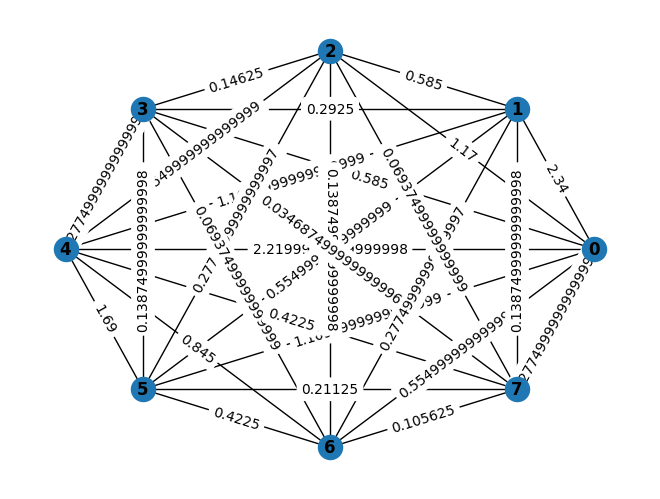

In [9]:
#Visualizando a cadeia Ising equivalente
op, offset = qubo.to_ising()
print(op)
G = nx.from_numpy_array(Quad)
G = nx.from_numpy_array(Quad)
pos=nx.circular_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G,pos = pos, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels);

* ## Encontrando a solução

In [10]:
# Solução exata clássica
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qubo)
print(exact_result.x)

[0. 0. 1. 1. 0. 1. 0. 0.]


In [11]:
# Recuperando a solução
x1 = 0
x2 = 0
for k in range(n):
    x1 = x1 + exact_result.x[k] * (2 ** -k)
    x2 = x2 + exact_result.x[k+4] * (2 ** -k)
print(x1,x2)

0.375 0.5


## Executando o QAOA na simulação ideal

In [12]:
backend = service.backend("ibmq_qasm_simulator")

shots = 5000

options = Options()

options.execution.shots = shots 

sampler= Sampler(backend,options=options)

#------------------------------------------------------------
qaoa_mes = QAOA(sampler=sampler, optimizer=COBYLA(), reps = 2, initial_point=[0.0, 0.0, 0.0, 0.0])

qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qubo)

In [13]:
x1 = 0
x2 = 0
for k in range(n):
    x1 = x1 + qaoa_result.x[k] * (2 ** -k)
    x2 = x2 + qaoa_result.x[k+4] * (2 ** -k)
print(x1,x2)

0.375 0.5


* ## Execuando o QAOA no computador quântico

In [16]:
backend = service.backend('ibm_perth')

options = Options()
    
options.resilience_level = 1
    
options.execution.shots = 2048

sampler= Sampler(backend,options=options)

#------------------------------------------------------------
qaoa_mes_r = QAOA(sampler=sampler, optimizer=COBYLA(), reps = 2, initial_point=[0.0, 0.0, 0.0, 0.0])

qaoa_r = MinimumEigenOptimizer(qaoa_mes_r)

qaoa_result_r = qaoa.solve(qubo)

In [18]:
x1 = 0
x2 = 0
for k in range(n):
    x1 = x1 + qaoa_result_r.x[k] * (2 ** -k)
    x2 = x2 + qaoa_result_r.x[k+4] * (2 ** -k)
print(x1,x2)

0.375 0.5


In [28]:
qaoa_mes_r.ansatz

In [29]:
circ = qaoa_mes_r.ansatz
circuit_drawer(circ, output='mpl')

Traceback (most recent call last):
  Cell In[29], line 2
    circuit_drawer(circ, output='mpl')
  File /opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/circuit_visualization.py:220 in circuit_drawer
    if circuit.clbits and (reverse_bits or wire_order is not None):
AttributeError: 'NoneType' object has no attribute 'clbits'

Use %tb to get the full traceback.


In [102]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=2, min_num_vars_optimizer=exact)
rqaoa_result = rqaoa.solve(qubo)

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 